In [1]:
!pip install --upgrade tensorflow wandb


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, initializers
from tensorflow.keras.applications import EfficientNetB0


from tensorflow.keras import optimizers, callbacks
import wandb
from wandb.integration.keras import WandbCallback


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataset(tf.keras.utils.Sequence):
    """
    TensorFlow Keras-compatible dataset loader without augmentations.
    Assumes two subfolders under root_dir: 'defect' and 'normal'.
    """
    def __init__(self, root_dir, batch_size=32, img_size=256, shuffle=True):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.classes = ['defect', 'normal']
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                path = os.path.join(class_dir, fname)
                if os.path.isfile(path):
                    self.image_paths.append(path)
                    self.labels.append(idx)

        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            tf.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:
            image = load_img(path, target_size=(self.img_size, self.img_size))
            image = img_to_array(image) / 255.0
            batch_images.append(image)

        return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels, dtype=tf.float32)


In [4]:
# ----------------------------
# Custom Layers & Utilities
# ----------------------------

class DropConnectDense(layers.Layer):
    def __init__(self, units, drop_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.drop_rate = drop_rate

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs, training=None):
        kernel = self.kernel
        if training and self.drop_rate > 0.0:
            drop_mask = tf.nn.dropout(tf.ones_like(kernel), rate=self.drop_rate)
            kernel = kernel * drop_mask
        return tf.matmul(inputs, kernel) + self.bias

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units, "drop_rate": self.drop_rate})
        return config

class BiasedDropout(layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, x, training=None):
        if not training or self.rate == 0.0:
            return x
        mask = tf.cast(tf.random.uniform(tf.shape(x)) > self.rate, x.dtype)
        return x * mask

class FlipoverDropout(layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, x, training=None):
        if not training or self.rate == 0.0:
            return x
        # Note: this is just a uniform scaling, not stochastic dropout
        return x * (1.0 - self.rate)

class DropBlock2D(layers.Layer):
    def __init__(self, keep_prob, block_size, **kwargs):
        super().__init__(**kwargs)
        self.keep_prob = keep_prob
        self.block_size = block_size

    def call(self, inputs, training=None):
        if not training or self.keep_prob == 1.0:
            return inputs

        input_shape = tf.shape(inputs)
        batch_size, height, width, channels = input_shape[0], input_shape[1], input_shape[2], input_shape[3]

        # Compute DropBlock mask gamma
        gamma = ((1.0 - self.keep_prob) * tf.cast(height * width, tf.float32) /
                 tf.cast((self.block_size ** 2) * ((height - self.block_size + 1) * (width - self.block_size + 1)), tf.float32))
        mask = tf.cast(tf.random.uniform((batch_size, height - self.block_size + 1, width - self.block_size + 1, channels)) < gamma, tf.float32)
        mask = tf.pad(mask,
                      [[0, 0],
                       [self.block_size // 2, self.block_size // 2],
                       [self.block_size // 2, self.block_size // 2],
                       [0, 0]])
        mask = tf.nn.max_pool(mask, ksize=[1, self.block_size, self.block_size, 1],
                              strides=[1, 1, 1, 1], padding='SAME')
        mask = 1 - mask
        # Scale output to preserve activation statistics
        return inputs * mask * (tf.cast(tf.size(mask), tf.float32) / tf.reduce_sum(mask))

    def get_config(self):
        config = super().get_config()
        config.update({"keep_prob": self.keep_prob, "block_size": self.block_size})
        return config

In [5]:
# def se_block(x, ratio=0.125):
#     """Squeeze-and-Excitation (channel attention) block."""
#     filters = x.shape[-1]
#     se = layers.GlobalAveragePooling2D()(x)
#     se = layers.Dense(int(filters * ratio), activation='relu')(se)
#     se = layers.Dense(filters, activation='sigmoid')(se)
#     se = layers.Reshape((1,1,filters))(se)
#     return layers.Multiply()([x, se])
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, channels, ratio=0.125, **kwargs):
        super().__init__(**kwargs)
        self.gap = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(int(channels * ratio), activation='relu')
        self.dense2 = layers.Dense(channels, activation='sigmoid')
        self.reshape = layers.Reshape((1, 1, channels))
        self.multiply = layers.Multiply()

    def call(self, inputs):
        se = self.gap(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = self.reshape(se)
        return self.multiply([inputs, se])


class PatchMerging(layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, x):
        return layers.AveragePooling2D(pool_size=self.pool_size, strides=self.pool_size)(x)


class TransformerEncoder(layers.Layer):
    def __init__(self, dim, num_heads, mlp_dim, attn_dropout=0.1, extra_dropout=None, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim//num_heads, dropout=attn_dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential([
            layers.Dense(mlp_dim, activation='gelu'),
            layers.Dense(dim),
        ])
        self.extra_dropout = extra_dropout

    def call(self, x, training=None):
        # Multi-head self-attention
        y = self.norm1(x)
        attn_out = self.attn(y, y, training=training)
        x = x + attn_out
        # MLP
        y2 = self.norm2(x)
        x = x + self.mlp(y2)
        # Optional dropout after transformer block
        if self.extra_dropout is not None:
            x = self.extra_dropout(x, training=training)
        return x


In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# ============ MAIN MODEL ============

class HybridModel(Model):
    def __init__(self, config, **kwargs):
        super().__init__(**kwargs)
        self.config = config

        # Backbone (frozen) - EfficientNetB0
        inputs = layers.Input(shape=(config['img_size'], config['img_size'], 3))
        backbone = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_tensor=inputs
        )

        # Extract intermediate feature maps
        self.backbone = Model(inputs=backbone.input, outputs=[
            backbone.get_layer('block3a_expand_activation').output,
            backbone.get_layer('block4a_expand_activation').output
        ])
        self.backbone.trainable = False

        # Adjust channel dimensions
        self.small_adjust = layers.Conv2D(96, 1)
        self.large_adjust = layers.Conv2D(144, 1)

        # Small (fine-scale) path
        self.small_conv = layers.Conv2D(96, 3, padding='same')
        act = config['activation']
        if act == 'swish':
            self.small_activation = layers.Activation('swish')
        elif act == 'gelu':
            self.small_activation = layers.Activation('gelu')
        else:
            self.small_activation = layers.Activation('relu')

        self.small_pool = PatchMerging(pool_size=2)
        # self.small_se = lambda x: se_block(x, ratio=config['se_ratio'])
        self.small_se = SEBlock(channels=96, ratio=config['se_ratio'])

        # Large (coarse-scale) path
        # self.large_se = lambda x: se_block(x, ratio=config['se_ratio'])
        self.large_se = SEBlock(channels=144, ratio=config['se_ratio'])

        # Fusion of paths
        self.fusion_conv = layers.Conv2D(192, 1,name='fusion_conv')
        if act == 'swish':
            self.fusion_activation = layers.Activation('swish')
        elif act == 'gelu':
            self.fusion_activation = layers.Activation('gelu')
        else:
            self.fusion_activation = layers.Activation('relu')

        self.fusion_dropout = self._create_dropout_layer(config, is_conv=True)

        # Merge tokens (patch merging)
        self.token_merging = PatchMerging(pool_size=2)

        # Transformer encoder blocks
        num_blocks = config.get('transformer_blocks', 2)
        self.transformer_layers = []
        for i in range(num_blocks):
            extra_drop = None
            if i == 0:
                extra_drop = self._create_dropout_layer(config, is_conv=False)
            self.transformer_layers.append(
                TransformerEncoder(
                    dim=192,
                    num_heads=config['attention_heads'],
                    mlp_dim=256,
                    attn_dropout=config['dropout_rate'],
                    extra_dropout=extra_drop
                )
            )

        # Positional embeddings for tokens
        self.pos_embedding = self.add_weight(
            shape=(1, 64, 192),  # base shape for 8×8 tokens
            initializer='random_normal',
            trainable=True
        )

        # Classification head
        self.head_layers = []
        for i in range(config['hidden_layers']):
            if config['dropout_type'] == 'dropconnect':
                self.head_layers.append(
                    DropConnectDense(config['hidden_units'], drop_rate=config['dropout_rate'])
                )
            else:
                self.head_layers.append(layers.Dense(config['hidden_units']))

            # Activation
            if act == 'swish':
                self.head_layers.append(layers.Activation('swish'))
            elif act == 'gelu':
                self.head_layers.append(layers.Activation('gelu'))
            else:
                self.head_layers.append(layers.Activation('relu'))

            # Dropout (if not using dropconnect and not last layer)
            if config['dropout_type'] != 'dropconnect' and i < config['hidden_layers'] - 1:
                self.head_layers.append(layers.Dropout(config['dropout_rate']))

        # Final output layer
        self.head_layers.extend([
            layers.Dense(1),
            layers.Activation('sigmoid')
        ])

    def _create_dropout_layer(self, config, is_conv=False):
        rate = config['dropout_rate']
        typ = config['dropout_type']

        if is_conv:
            if typ == 'dropblock':
                # return lambda x, training=None: DropBlock2D(
                #     keep_prob=1 - rate,
                #     block_size=config.get('dropblock_size', 7)
                # )(x, training=training)
                return DropBlock2D(
                keep_prob=1 - rate,
                block_size=config.get('dropblock_size', 7)
            )
            elif typ == 'standard':
                  return layers.SpatialDropout2D(rate)
                # return lambda x, training=None: layers.SpatialDropout2D(rate)(x, training=training)
            elif typ == 'biased_dropout':
                  return BiasedDropout(rate)
                # return lambda x, training=None: BiasedDropout(rate)(x, training=training)
            elif typ == 'flipover':
                  return FlipoverDropout(rate)
                # return lambda x, training=None: FlipoverDropout(rate)(x, training=training)
        else:
            if typ == 'dropconnect':
                return None
            else:
                return layers.Dropout(rate)
        return None

    def call(self, x, training=None):
        # Backbone feature extraction
        feat_small, feat_large = self.backbone(x, training=False)

        # Channel adjustment
        feat_small = self.small_adjust(feat_small)
        feat_large = self.large_adjust(feat_large)

        # Small path
        x_small = self.small_conv(feat_small)
        x_small = self.small_activation(x_small)
        x_small = self.small_pool(x_small)
        x_small = self.small_se(x_small)

        # Large path
        x_large = self.large_se(feat_large)

        # Fuse features
        x = tf.concat([x_large, x_small], axis=-1)
        x = self.fusion_conv(x)
        x = self.fusion_activation(x)
        if self.fusion_dropout is not None:
            # x = self.fusion_dropout(x, training=training)
              if isinstance(self.fusion_dropout, (layers.SpatialDropout2D, DropBlock2D, BiasedDropout, FlipoverDropout)):
                  x = self.fusion_dropout(x, training=training)
              else:
                  x = self.fusion_dropout(x)
        # Token merging
        x = self.token_merging(x)

        # Flatten spatial dimensions into sequence
        batch = tf.shape(x)[0]
        channels = x.shape[-1]
        x_flat = tf.reshape(x, [batch, -1, channels])
        seq_len = tf.shape(x_flat)[1]

        # Resize positional embeddings if needed
        pe = tf.transpose(self.pos_embedding, [0, 2, 1])  # [1, C, 64]
        pe = tf.expand_dims(pe, -1)                       # [1, C, 64, 1]
        pe = tf.image.resize(pe, [channels, seq_len], method='bilinear')
        pe = tf.squeeze(pe, -1)                           # [1, C, seq_len]
        pos_emb = tf.transpose(pe, [0, 2, 1])             # [1, seq_len, C]

        # Add positional embedding
        x_flat = x_flat + pos_emb

        # Transformer encoder blocks
        for encoder in self.transformer_layers:
            x_flat = encoder(x_flat, training=training)

        # Global average pooling
        x = tf.reduce_mean(x_flat, axis=1)

        # Classification head
        for layer in self.head_layers:
            if isinstance(layer, DropConnectDense):
                x = layer(x, training=training)
            else:
                x = layer(x)

        return x

    def get_fusion_conv_output(self, x, training=False):
        # Run only up to fusion_conv layer
         feat_small, feat_large = self.backbone(x, training=False)
         feat_small = self.small_adjust(feat_small)
         feat_large = self.large_adjust(feat_large)

         x_small = self.small_conv(feat_small)
         x_small = self.small_activation(x_small)
         x_small = self.small_pool(x_small)
         x_small = self.small_se(x_small)

         x_large = self.large_se(feat_large)
         x = tf.concat([x_large, x_small], axis=-1)
         x = self.fusion_conv(x)
         return x  # output from fusion_conv
    def gradcam_forward(self, x, training=False):
        # — exactly the same layers as in call(), up through fusion_conv —
        feat_small, feat_large = self.backbone(x, training=False)
        feat_small = self.small_adjust(feat_small)
        feat_large = self.large_adjust(feat_large)

        x_small = self.small_conv(feat_small)
        x_small = self.small_activation(x_small)
        x_small = self.small_pool(x_small)
        x_small = self.small_se(x_small)

        x_large = self.large_se(feat_large)

        concat = tf.concat([x_large, x_small], axis=-1)
        conv_outputs = self.fusion_conv(concat)
        conv_activated = self.fusion_activation(conv_outputs)
        if self.fusion_dropout is not None:
            if isinstance(self.fusion_dropout, (layers.SpatialDropout2D, DropBlock2D, BiasedDropout, FlipoverDropout)):
                conv_activated = self.fusion_dropout(conv_activated, training=training)
            else:
                conv_activated = self.fusion_dropout(conv_activated)

        # — then continue exactly as in call(), to get final preds —
        x = self.token_merging(conv_activated)
        batch = tf.shape(x)[0]; channels = x.shape[-1]
        x_flat = tf.reshape(x, [batch, -1, channels])
        seq_len = tf.shape(x_flat)[1]

        pe = tf.transpose(self.pos_embedding, [0, 2, 1])
        pe = tf.expand_dims(pe, -1)
        pe = tf.image.resize(pe, [channels, seq_len], method='bilinear')
        pe = tf.squeeze(pe, -1)
        pos_emb = tf.transpose(pe, [0, 2, 1])

        x_flat = x_flat + pos_emb
        for encoder in self.transformer_layers:
            x_flat = encoder(x_flat, training=training)

        x = tf.reduce_mean(x_flat, axis=1)
        for layer in self.head_layers:
            if isinstance(layer, DropConnectDense):
                x = layer(x, training=training)
            else:
                x = layer(x)

        preds = x
        # ← return BOTH conv_outputs (pre‑activation) AND final predictions
        return conv_outputs, preds


In [7]:
    # def gradcam_forward(self, x, training=False):
    #     # — exactly the same layers as in call(), up through fusion_conv —
    #     feat_small, feat_large = self.backbone(x, training=False)
    #     feat_small = self.small_adjust(feat_small)
    #     feat_large = self.large_adjust(feat_large)

    #     x_small = self.small_conv(feat_small)
    #     x_small = self.small_activation(x_small)
    #     x_small = self.small_pool(x_small)
    #     x_small = self.small_se(x_small)

    #     x_large = self.large_se(feat_large)

    #     concat = tf.concat([x_large, x_small], axis=-1)
    #     conv_outputs = self.fusion_conv(concat)
    #     conv_activated = self.fusion_activation(conv_outputs)
    #     if self.fusion_dropout is not None:
    #         if isinstance(self.fusion_dropout, (layers.SpatialDropout2D, DropBlock2D, BiasedDropout, FlipoverDropout)):
    #             conv_activated = self.fusion_dropout(conv_activated, training=training)
    #         else:
    #             conv_activated = self.fusion_dropout(conv_activated)

    #     # — then continue exactly as in call(), to get final preds —
    #     x = self.token_merging(conv_activated)
    #     batch = tf.shape(x)[0]; channels = x.shape[-1]
    #     x_flat = tf.reshape(x, [batch, -1, channels])
    #     seq_len = tf.shape(x_flat)[1]

    #     pe = tf.transpose(self.pos_embedding, [0, 2, 1])
    #     pe = tf.expand_dims(pe, -1)
    #     pe = tf.image.resize(pe, [channels, seq_len], method='bilinear')
    #     pe = tf.squeeze(pe, -1)
    #     pos_emb = tf.transpose(pe, [0, 2, 1])

    #     x_flat = x_flat + pos_emb
    #     for encoder in self.transformer_layers:
    #         x_flat = encoder(x_flat, training=training)

    #     x = tf.reduce_mean(x_flat, axis=1)
    #     for layer in self.head_layers:
    #         if isinstance(layer, DropConnectDense):
    #             x = layer(x, training=training)
    #         else:
    #             x = layer(x)

    #     preds = x
    #     # ← return BOTH conv_outputs (pre‑activation) AND final predictions
    #     return conv_outputs, preds

In [8]:
# ----------------------------
# Hyperparameter Sweep Config
# ----------------------------
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_auc', 'goal': 'maximize'},
    'parameters': {
        'optimizer': {'values': ['Adam', 'AdamW', 'Nadam', 'SGD']},
        'lr': {'min': 1e-5, 'max': 1e-3},
        'momentum': {'values': [0.8, 0.9]},  # now always included but handled in code
        'dropout_type': {'values': ['standard', 'dropblock', 'dropconnect', 'biased_dropout', 'flipover']},
        'dropout_rate': {'min': 0.2, 'max': 0.5},
        'activation': {'values': ['swish', 'relu', 'gelu']},
        'hidden_layers': {'values': [2, 3]},
        'hidden_units': {'values': [64, 128]},
        'scheduler': {'values': ['plateau', 'cosine', 'exponential']},
        'batch_size': {'values': [32, 64]},
        'attention_heads': {'values': [2, 4]},
        'transformer_blocks': {'values': [1, 2, 3]},  # tune number of transformer layers
        'se_ratio': {'min': 4, 'max': 16},
        'img_size': {'value': 256},
    },
    'early_terminate': {
        'type': 'hyperband',
        'min_iter': 3,
        'eta': 2
    }
}

In [9]:
# Mount Google Drive (for Colab)
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:

import os
import wandb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Precision, Recall
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, precision_score, recall_score, f1_score,accuracy_score,
    precision_recall_curve, auc as sk_auc
)
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        img_size = config.img_size
        # Load training and validation datasets
        train_ds = tf.keras.utils.image_dataset_from_directory(
            '/content/drive/MyDrive/VGG/train',
            labels='inferred', label_mode='binary',
            image_size=(256, 256), batch_size=config.batch_size, shuffle=True
        )
        val_ds = tf.keras.utils.image_dataset_from_directory(
            '/content/drive/MyDrive/VGG/valid',
            labels='inferred', label_mode='binary',
            image_size=(256, 256), batch_size=config.batch_size, shuffle=False
        )
        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

        # Build the hybrid model (as defined in the provided code)
        model = HybridModel(config)
        # Dummy call to initialize model.input for Grad-CAM
        dummy_input = tf.keras.Input(shape=(img_size, img_size, 3))
        _ = model(dummy_input)


        # Choose optimizer based on sweep config
        optimizer_name = config.optimizer
        lr = config.lr
        # Setup learning rate scheduler if needed
        if config.scheduler == 'cosine':
         lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
         initial_learning_rate=lr,
         decay_steps=1000,  # you can sweep this too
         alpha=0.1
         )
        elif config.scheduler == 'exponential':
         lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
         initial_learning_rate=lr,
         decay_steps=1000,
         decay_rate=0.9
         )
        else:
         lr_schedule = lr  # No scheduling, keep as fixed value
        if optimizer_name == 'SGD':
           optimizer = tf.keras.optimizers.SGD(
           learning_rate=lr_schedule,
           momentum=config.get('momentum', 0.9)
        )
        elif optimizer_name == 'Adam':
          optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule,)
        elif optimizer_name == 'AdamW':
          optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule,)
        elif optimizer_name == 'Nadam':
          optimizer = tf.keras.optimizers.Nadam(learning_rate=lr_schedule,)
        else:
          raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        # Compile with additional metrics: accuracy, precision, recall (F1 will be computed manually)
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[AUC(name='auc'), BinaryAccuracy(name='accuracy'),
                     Precision(name='precision'), Recall(name='recall')]
        )

        # Early stopping based on validation loss
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=config.get('early_stop_patience', 7),
            restore_best_weights=True
        )
        callbacks=[
                WandbMetricsLogger(log_freq='epoch'),
                WandbModelCheckpoint(filepath=f"model_{wandb.run.id}.keras"),
                early_stopping
            ]
        if config.scheduler == 'plateau':
         reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
         monitor='val_loss',
         factor=0.5,
         patience=3,
         min_lr=1e-6,
         verbose=1
         )
         callbacks.append(reduce_lr)

        # Train the model
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=30,
            callbacks=callbacks
        )

        # Plot training/validation Loss and AUC (as before)
        epochs_range = range(1, len(history.history['loss']) + 1)
        plt.figure(figsize=(10, 4))
        plt.plot(epochs_range, history.history['loss'], label='Train Loss')
        plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
        wandb.log({'loss_curve': wandb.Image(plt)})
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(epochs_range, history.history['auc'], label='Train AUC')
        plt.plot(epochs_range, history.history['val_auc'], label='Val AUC')
        plt.title('AUC over Epochs')
        plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend()
        wandb.log({'auc_curve': wandb.Image(plt)})
        plt.show()

        plt.figure()
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.legend()
        wandb.log({'accuracy_curve': wandb.Image(plt)})

        # ==== Additional Validation Metrics and Plots ====

        # Compute predictions on the validation set
        val_probs = model.predict(val_ds).flatten()
        val_labels = np.concatenate([y.numpy() for x, y in val_ds])
        val_pred_labels = (val_probs > 0.5).astype(np.int32)

        # Compute precision, recall, F1 on validation data
        val_precision_postepoch = precision_score(val_labels, val_pred_labels)
        val_recall_postepoch = recall_score(val_labels, val_pred_labels)
        val_f1_postepoch = f1_score(val_labels, val_pred_labels)
        val_accuracy_postepoch = accuracy_score(val_labels, val_pred_labels)

        # Log the scalar metrics to W&B
        wandb.log({
            'val_precision_postepoch': val_precision_postepoch,
            'val_recall_postepoch': val_recall_postepoch,
            'val_f1_postepoch': val_f1_postepoch,
            'val_accuracy_postepoch': val_accuracy_postepoch
        })

        # Confusion matrix on validation data
        cm = confusion_matrix(val_labels, val_pred_labels)
        plt.figure(figsize=(4, 4))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix (Validation)')
        plt.colorbar()
        classes = ['Negative','Positive']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        # Annotate counts in the cells
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
        plt.xlabel('Predicted label'); plt.ylabel('True label')
        wandb.log({'confusion_matrix_val': wandb.Image(plt)})
        plt.show()

        # Precision-Recall curve on validation data
        precisions, recalls, _ = precision_recall_curve(val_labels, val_probs)
        pr_auc = sk_auc(recalls, precisions)
        plt.figure(figsize=(6, 5))
        plt.plot(recalls, precisions, label=f'PR AUC = {pr_auc:.2f}')
        plt.title('Precision-Recall Curve (Validation)')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend()
        wandb.log({'pr_curve_val': wandb.Image(plt)})
        plt.show()

        # Force a dummy forward pass so all layers—including fusion_conv—are built
        _ = model.predict(
        np.zeros((1, img_size, img_size, 3), dtype=np.float32),
        verbose=0
        )
        # ============ GRAD-CAM UTILS ============
        last_conv_name = 'fusion_conv'

        def make_gradcam_heatmap(img_array, model):
            with tf.GradientTape() as tape:
                conv_outputs, preds = model.gradcam_forward(img_array, training=False)
                tape.watch(conv_outputs)

                pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]



            grads        = tape.gradient(class_channel, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_outputs = conv_outputs[0]
            heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
            return heatmap.numpy()

        def superimpose_gradcam(img_path, heatmap, alpha=0.4):
            # Use captured img_size
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img)
            heatmap_uint8 = np.uint8(255 * heatmap)
            jet = plt.cm.get_cmap("jet")
            jet_colors = jet(np.arange(256))[:, :3]
            jet_heatmap = jet_colors[heatmap_uint8]
            jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
            jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
            jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
            superimposed = jet_heatmap * alpha + img
            return tf.keras.preprocessing.image.array_to_img(superimposed)

        # Generate and log Grad-CAM for a few validation samples
        sample_dir = '/content/drive/MyDrive/VGG/valid/defect'
        for i, fname in enumerate(tf.io.gfile.listdir(sample_dir)[:2]):
            img_path = os.path.join(sample_dir, fname)

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))

            img_arr = tf.keras.preprocessing.image.img_to_array(img)
            img_arr = np.expand_dims(img_arr, axis=0)
            img_arr = preprocess_input(img_arr)

            # img_arr = tf.keras.preprocessing.image.img_to_array(
            #     tf.keras.preprocessing.image.load_img(img_path, (img_size, img_size))
            # )
            heatmap = make_gradcam_heatmap(img_arr, model)
            print(f"[Grad‑CAM] {fname}: heatmap range {heatmap.min():.3f}–{heatmap.max():.3f}")
            cam_img = superimpose_gradcam(img_path, heatmap)
            wandb.log({f'gradcam_val_{i}': wandb.Image(cam_img)})

        return model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Create sweep with ID: 8rpvsoke
Sweep URL: https://wandb.ai/kota-national-institute-of-technology-hamirpur/confinal-tuning/sweeps/8rpvsoke


wandb: Agent Starting Run: n9k8ipmv with config:
wandb: 	activation: relu
wandb: 	attention_heads: 2
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.42078051417574935
wandb: 	dropout_type: biased_dropout
wandb: 	hidden_layers: 2
wandb: 	hidden_units: 128
wandb: 	img_size: 256
wandb: 	lr: 4.162317195684044e-05
wandb: 	momentum: 0.9
wandb: 	optimizer: Adam
wandb: 	scheduler: exponential
wandb: 	se_ratio: 10
wandb: 	transformer_blocks: 3
wandb: Currently logged in as: kotakeshava (kota-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.5367 - auc: 0.5482 - loss: 0.7116 - precision: 0.5095 - recall: 0.4455 - val_accuracy: 0.6407 - val_auc: 0.7641 - val_loss: 0.5887 - val_precision: 0.6647 - val_recall: 0.5750
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 588ms/step - accuracy: 0.6810 - auc: 0.7458 - loss: 0.5922 - precision: 0.6756 - recall: 0.7000 - val_accuracy: 0.6759 - val_auc: 0.8353 - val_loss: 0.5933 - val_precision: 0.6099 - val_recall: 0.9850
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 621ms/step - accuracy: 0.7109 - auc: 0.7893 - loss: 0.5507 - precision: 0.6816 - recall: 0.7849 - val_accuracy: 0.7663 - val_auc: 0.8631 - val_loss: 0.4754 - val_precision: 0.6989 - val_recall: 0.9400
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 566ms/step - accuracy: 0.7527 - auc: 0.8384 - loss: 0.4922 - precision: 0.7357 - recall: 0.7855 - val_accuracy: 0.8141 - val_auc: 0.8962 - val_loss: 0.4125 - val_precision: 0.7461 - val_recall: 0.9550
Epoch 5/30
50/50 ━━━━━━━━━━━━━

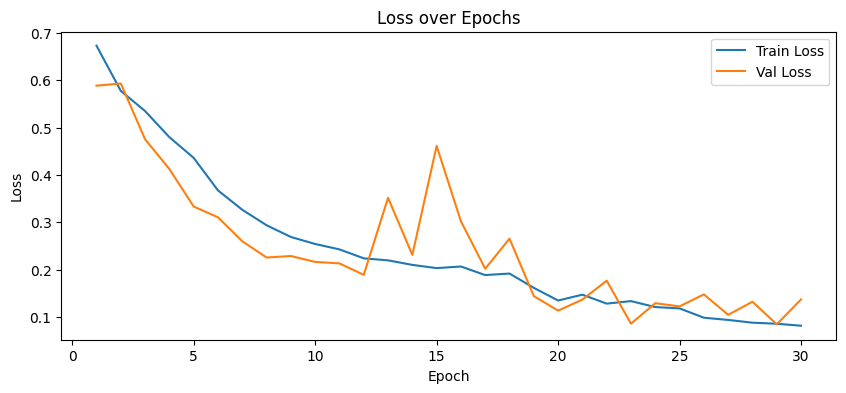

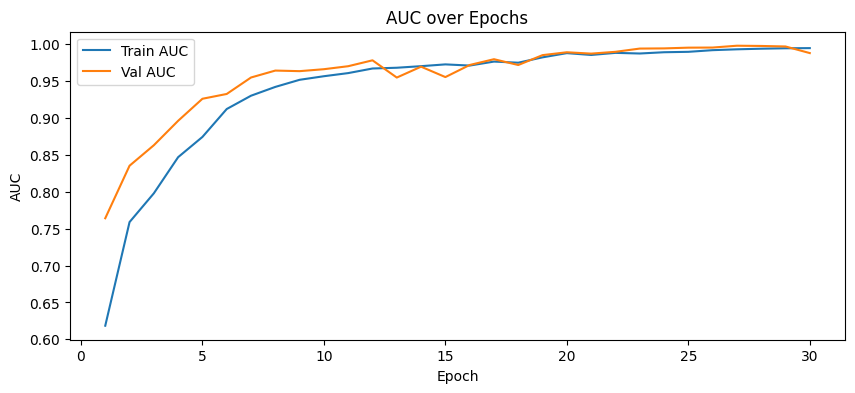

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 972ms/step


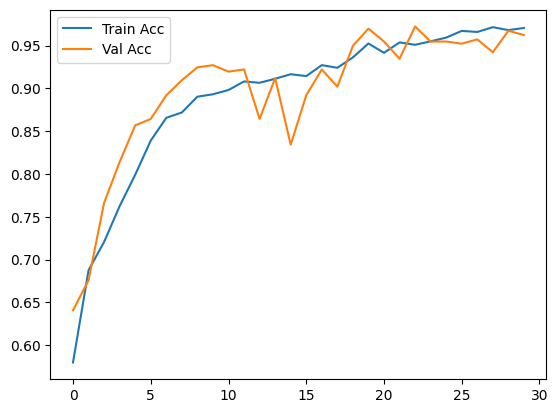

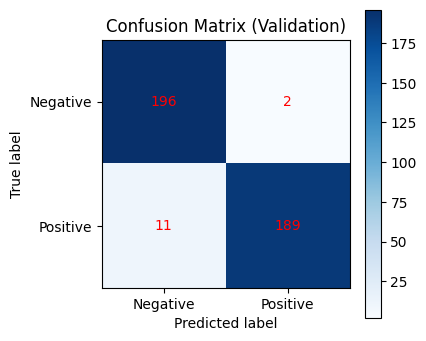

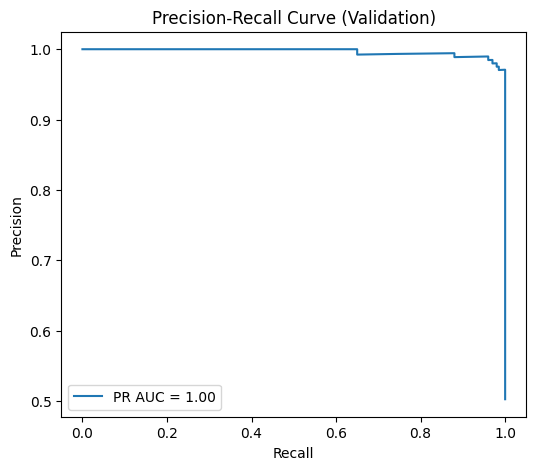

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


[Grad‑CAM] Yellow cloth_041.png: heatmap range 0.000–1.000


/tmp/ipython-input-1122171184.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


[Grad‑CAM] Yellow cloth_a21e7e9847084731b0d81823126eaba8.png: heatmap range 0.000–0.955


epoch/accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████
epoch/auc,▁▄▄▅▆▆▇▇▇▇▇▇██████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/precision,▁▃▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█████████
epoch/recall,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch/val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▆▇▅▆▇▇███▇█████▇██
epoch/val_auc,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch/val_loss,██▆▆▄▄▃▃▃▃▃▂▅▃▆▄▃▃▂▁▂▂▁▂▂▂▁▂▁▂
epoch/val_precision,▂▁▃▄▅▅▆▆▇▆▇▆▇▇▇█▇▇▇▇██████████


wandb: Agent Starting Run: jdkymaew with config:
wandb: 	activation: swish
wandb: 	attention_heads: 2
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2389914143923835
wandb: 	dropout_type: dropblock
wandb: 	hidden_layers: 2
wandb: 	hidden_units: 128
wandb: 	img_size: 256
wandb: 	lr: 0.0004191128308224681
wandb: 	momentum: 0.9
wandb: 	optimizer: AdamW
wandb: 	scheduler: exponential
wandb: 	se_ratio: 7
wandb: 	transformer_blocks: 2


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 698ms/step - accuracy: 0.5622 - auc: 0.5951 - loss: 0.6955 - precision: 0.5600 - recall: 0.4681 - val_accuracy: 0.5955 - val_auc: 0.8304 - val_loss: 0.7439 - val_precision: 0.5543 - val_recall: 0.9950
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - accuracy: 0.6627 - auc: 0.7485 - loss: 0.5861 - precision: 0.6465 - recall: 0.6966 - val_accuracy: 0.7839 - val_auc: 0.9073 - val_loss: 0.4948 - val_precision: 0.6993 - val_recall: 1.0000
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accuracy: 0.7984 - auc: 0.8627 - loss: 0.4514 - precision: 0.7550 - recall: 0.8721 - val_accuracy: 0.8568 - val_auc: 0.9571 - val_loss: 0.3221 - val_precision: 0.9040 - val_recall: 0.8000
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 646ms/step - accuracy: 0.8658 - auc: 0.9449 - loss: 0.2893 - precision: 0.8450 - recall: 0.8882 - val_accuracy: 0.8920 - val_auc: 0.9780 - val_loss: 0.2160 - val_precision: 0.9645 - val_recall: 0.8150
Epoch 5/30
50/50 ━━━━━━━━━━━

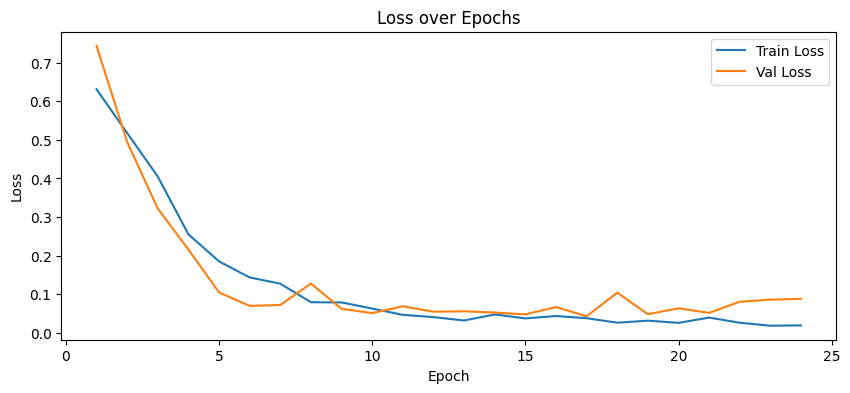

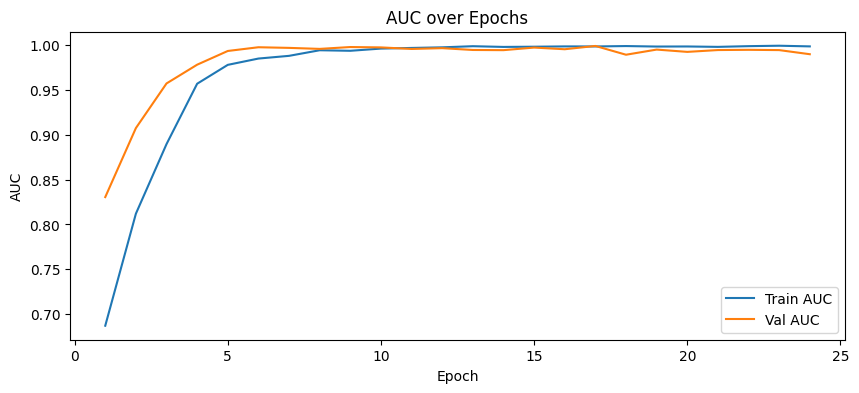

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 871ms/step


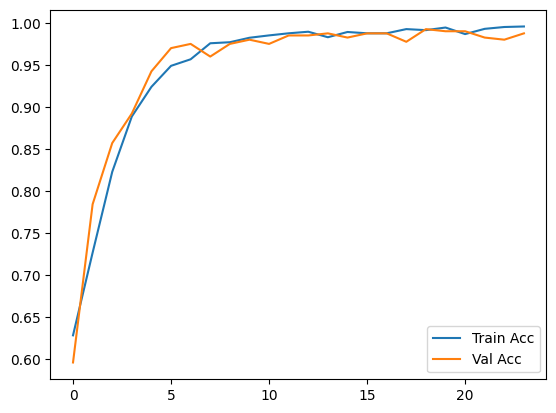

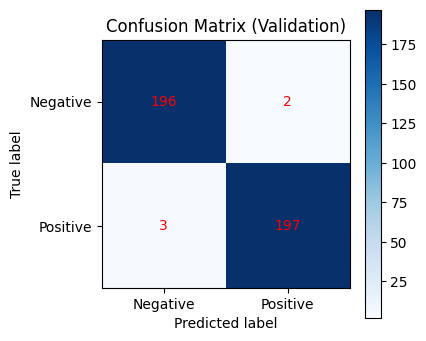

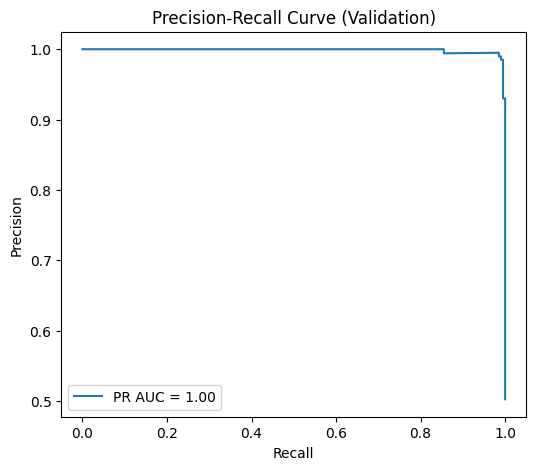

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


[Grad‑CAM] Yellow cloth_041.png: heatmap range 0.000–1.000


/tmp/ipython-input-1122171184.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


[Grad‑CAM] Yellow cloth_a21e7e9847084731b0d81823126eaba8.png: heatmap range 0.000–0.997


epoch/accuracy,▁▃▅▆▇▇▇█████████████████
epoch/auc,▁▄▆▇████████████████████
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
epoch/loss,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▁▃▄▆▆▇▇█▇███████████████
epoch/recall,▁▄▆▇▇▇▇█████████████████
epoch/val_accuracy,▁▄▆▆▇██▇████████████████
epoch/val_auc,▁▄▆▇████████████████████
epoch/val_loss,█▆▄▃▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch/val_precision,▁▃▇█▇███▇███████████████


wandb: Agent Starting Run: 2o22ow5v with config:
wandb: 	activation: swish
wandb: 	attention_heads: 4
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.38140773615816514
wandb: 	dropout_type: standard
wandb: 	hidden_layers: 3
wandb: 	hidden_units: 128
wandb: 	img_size: 256
wandb: 	lr: 0.0006980158513573563
wandb: 	momentum: 0.9
wandb: 	optimizer: Nadam
wandb: 	scheduler: plateau
wandb: 	se_ratio: 9
wandb: 	transformer_blocks: 1


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 731ms/step - accuracy: 0.5624 - auc: 0.5944 - loss: 0.6771 - precision: 0.5677 - recall: 0.5105 - val_accuracy: 0.7211 - val_auc: 0.8195 - val_loss: 0.5448 - val_precision: 0.6943 - val_recall: 0.7950 - learning_rate: 6.9802e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 576ms/step - accuracy: 0.6872 - auc: 0.7613 - loss: 0.5772 - precision: 0.6684 - recall: 0.7455 - val_accuracy: 0.8266 - val_auc: 0.9387 - val_loss: 0.3492 - val_precision: 0.8922 - val_recall: 0.7450 - learning_rate: 6.9802e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.8745 - auc: 0.9427 - loss: 0.3016 - precision: 0.8513 - recall: 0.9075 - val_accuracy: 0.9146 - val_auc: 0.9757 - val_loss: 0.2041 - val_precision: 0.9109 - val_recall: 0.9200 - learning_rate: 6.9802e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.8981 - auc: 0.9686 - loss: 0.2204 - precision: 0.8665 - recall: 0.9377 - val_accuracy: 0.8894 - val_auc: 0.9878 - val_lo

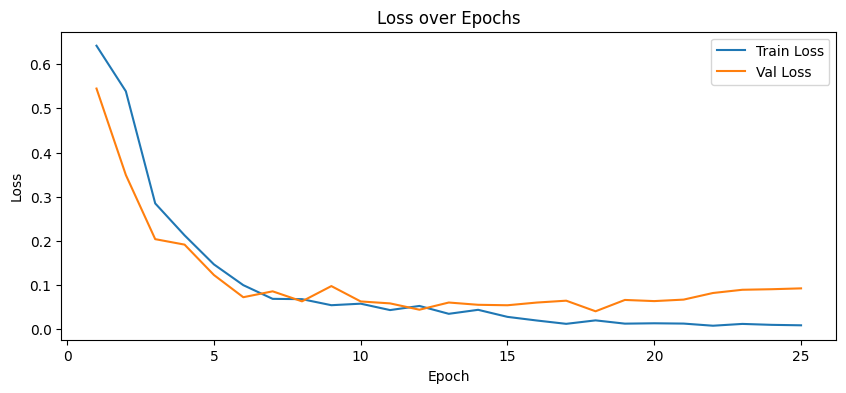

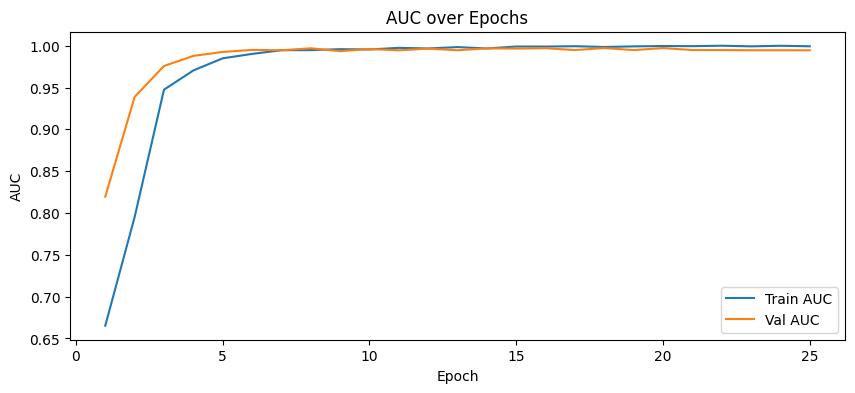

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 750ms/step


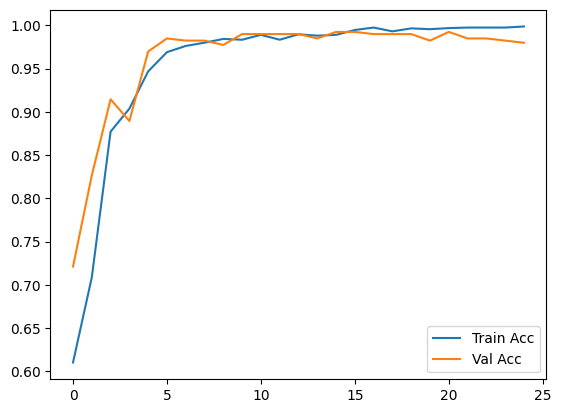

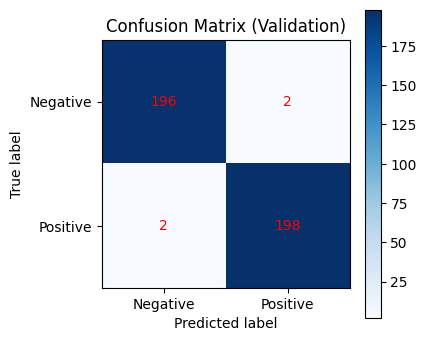

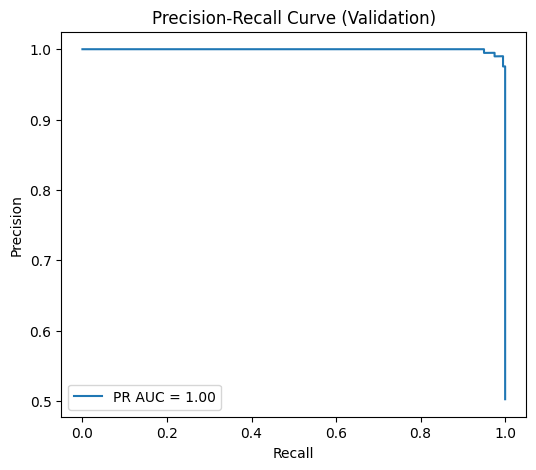

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


[Grad‑CAM] Yellow cloth_041.png: heatmap range 0.000–1.000


/tmp/ipython-input-1122171184.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


[Grad‑CAM] Yellow cloth_a21e7e9847084731b0d81823126eaba8.png: heatmap range 0.000–0.000


epoch/accuracy,▁▃▆▆▇▇███████████████████
epoch/auc,▁▄▇▇█████████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,███████████████▄▄▄▄▄▄▂▂▂▁
epoch/loss,█▇▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▁▂▅▆▇▇▇██████████████████
epoch/recall,▁▄▇▇▇████████████████████
epoch/val_accuracy,▁▄▆▅▇████████████████████
epoch/val_auc,▁▆▇██████████████████████
epoch/val_loss,█▅▃▃▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
epoch/val_precision,▁▆▆▄█████████████████████


wandb: Agent Starting Run: jd0nalh8 with config:
wandb: 	activation: relu
wandb: 	attention_heads: 2
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.34859543144005145
wandb: 	dropout_type: dropconnect
wandb: 	hidden_layers: 3
wandb: 	hidden_units: 64
wandb: 	img_size: 256
wandb: 	lr: 0.0008903972166288311
wandb: 	momentum: 0.9
wandb: 	optimizer: AdamW
wandb: 	scheduler: plateau
wandb: 	se_ratio: 6
wandb: 	transformer_blocks: 1


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 717ms/step - accuracy: 0.5065 - auc: 0.5094 - loss: 0.8380 - precision: 0.5084 - recall: 0.6906 - val_accuracy: 0.4975 - val_auc: 0.6973 - val_loss: 0.7050 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.9040e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 578ms/step - accuracy: 0.4950 - auc: 0.4973 - loss: 0.8484 - precision: 0.5014 - recall: 0.5075 - val_accuracy: 0.5327 - val_auc: 0.7173 - val_loss: 0.7245 - val_precision: 0.5181 - val_recall: 1.0000 - learning_rate: 8.9040e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 593ms/step - accuracy: 0.5127 - auc: 0.5489 - loss: 0.7083 - precision: 0.5238 - recall: 0.5527 - val_accuracy: 0.6658 - val_auc: 0.7544 - val_loss: 0.6043 - val_precision: 0.8018 - val_recall: 0.4450 - learning_rate: 8.9040e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 586ms/step - accuracy: 0.6574 - auc: 0.7177 - loss: 0.6145 - precision: 0.6671 - recall: 0.6499 - val_accuracy: 0.8317 - val_auc: 0.9412 

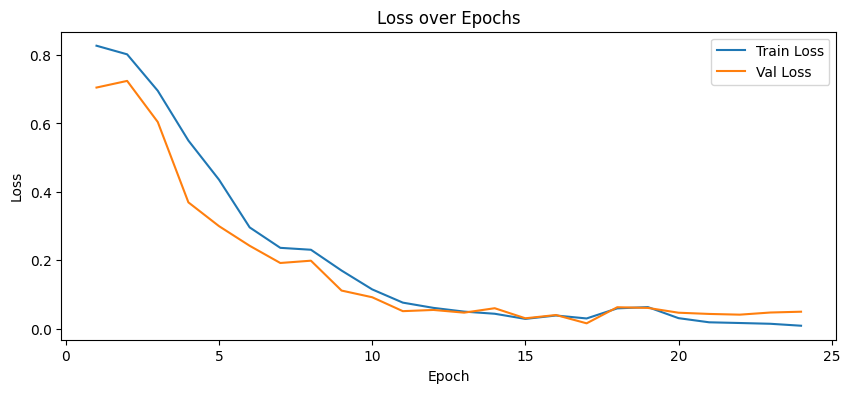

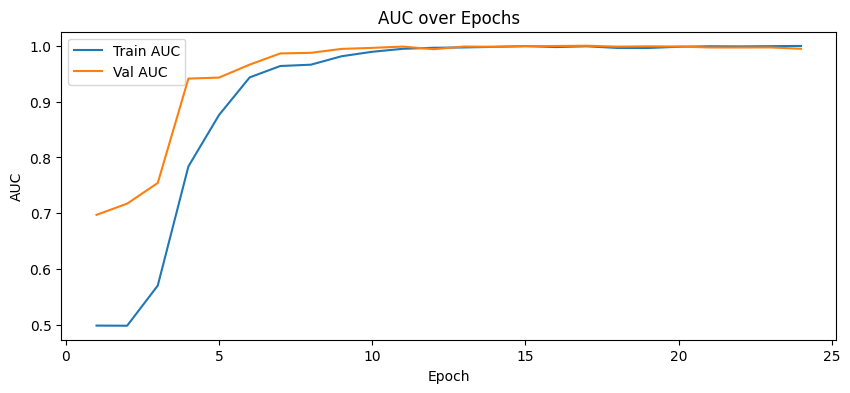

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 907ms/step


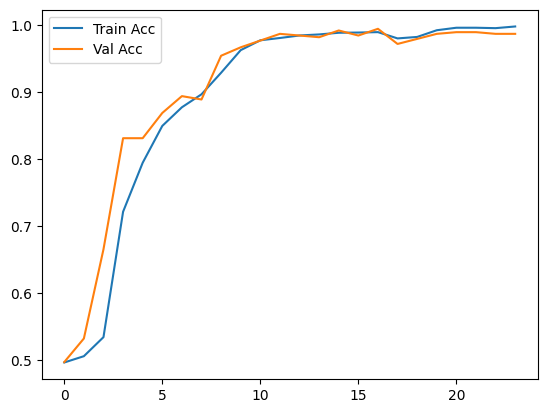

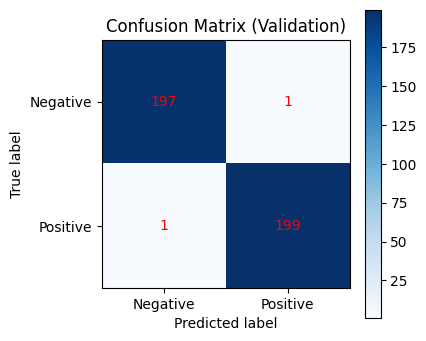

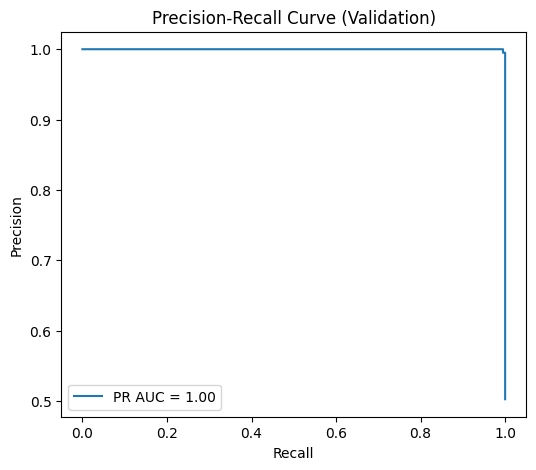

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


[Grad‑CAM] Yellow cloth_041.png: heatmap range 0.000–0.875


/tmp/ipython-input-1122171184.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


[Grad‑CAM] Yellow cloth_a21e7e9847084731b0d81823126eaba8.png: heatmap range 0.000–0.006


epoch/accuracy,▁▁▂▄▅▆▆▇▇███████████████
epoch/auc,▁▁▂▅▆▇▇█████████████████
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,████████████████████▃▃▃▁
epoch/loss,██▇▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▁▁▁▄▆▆▆▇▇▇██████████████
epoch/recall,▂▁▃▄▄▆▆▇▇███████████████
epoch/val_accuracy,▁▁▃▆▆▆▇▇▇███████████████
epoch/val_auc,▁▁▂▇▇▇██████████████████
epoch/val_loss,██▇▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_precision,▁▅▇▇▇▇▇▇▇███████████████


wandb: Agent Starting Run: buvzbykm with config:
wandb: 	activation: gelu
wandb: 	attention_heads: 4
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2210332028213482
wandb: 	dropout_type: biased_dropout
wandb: 	hidden_layers: 3
wandb: 	hidden_units: 128
wandb: 	img_size: 256
wandb: 	lr: 5.945387654681102e-05
wandb: 	momentum: 0.8
wandb: 	optimizer: Nadam
wandb: 	scheduler: plateau
wandb: 	se_ratio: 4
wandb: 	transformer_blocks: 2


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 730ms/step - accuracy: 0.5930 - auc: 0.6221 - loss: 0.6648 - precision: 0.5904 - recall: 0.5153 - val_accuracy: 0.7538 - val_auc: 0.8364 - val_loss: 0.5220 - val_precision: 0.7772 - val_recall: 0.7150 - learning_rate: 5.9454e-05
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 557ms/step - accuracy: 0.7322 - auc: 0.8029 - loss: 0.5353 - precision: 0.7127 - recall: 0.7738 - val_accuracy: 0.7789 - val_auc: 0.8705 - val_loss: 0.4535 - val_precision: 0.7718 - val_recall: 0.7950 - learning_rate: 5.9454e-05
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.7630 - auc: 0.8392 - loss: 0.4858 - precision: 0.7332 - recall: 0.8155 - val_accuracy: 0.7563 - val_auc: 0.8860 - val_loss: 0.4995 - val_precision: 0.9055 - val_recall: 0.5750 - learning_rate: 5.9454e-05
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 617ms/step - accuracy: 0.8064 - auc: 0.8746 - loss: 0.4417 - precision: 0.7838 - recall: 0.8406 - val_accuracy: 0.8367 - val_auc: 0.9265 - val_lo

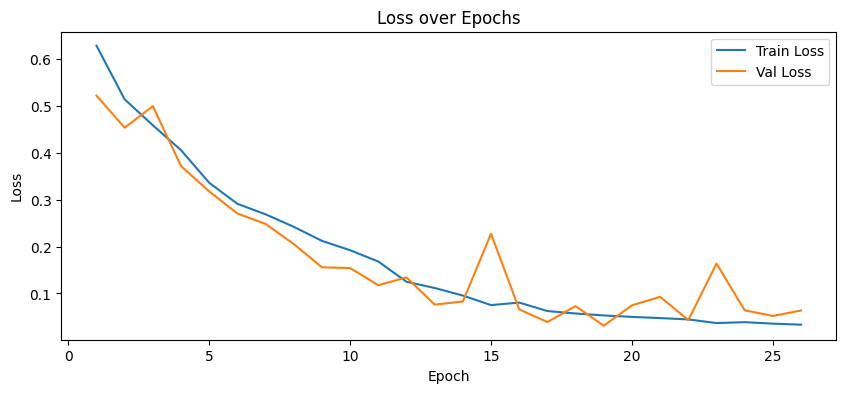

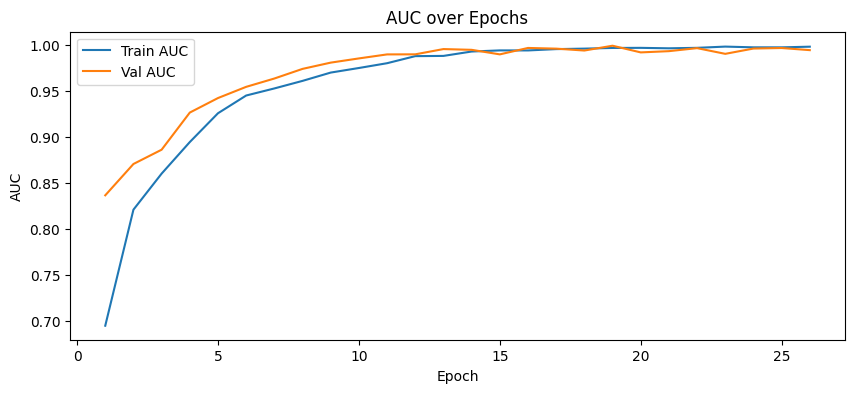

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 256, 256, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 800ms/step


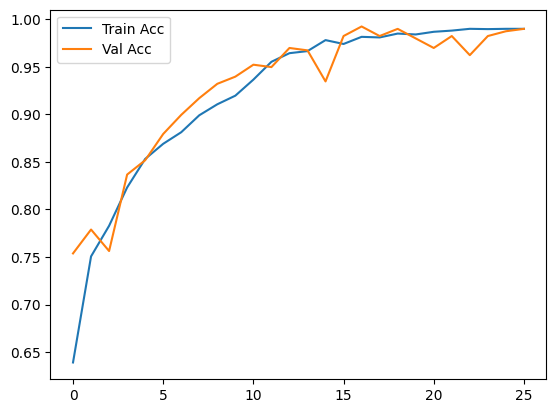

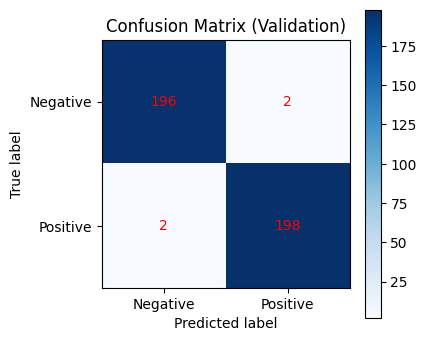

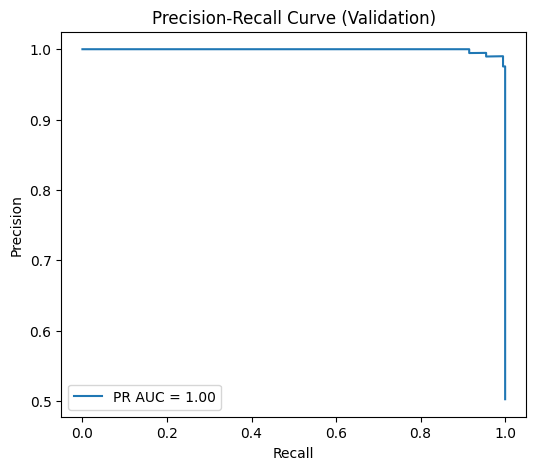

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


[Grad‑CAM] Yellow cloth_041.png: heatmap range 0.000–1.000


/tmp/ipython-input-1122171184.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


[Grad‑CAM] Yellow cloth_a21e7e9847084731b0d81823126eaba8.png: heatmap range 0.000–0.369


epoch/accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇█████████████
epoch/auc,▁▄▅▆▆▇▇▇▇▇████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,██████████████████████▃▃▃▁
epoch/loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch/precision,▁▃▃▄▅▅▅▆▆▆▇▇▇▇████████████
epoch/recall,▁▄▅▆▆▆▆▇▇▇▇▇██████████████
epoch/val_accuracy,▁▂▁▃▄▅▅▆▆▆▇▇▇▇▆█████▇█▇███
epoch/val_auc,▁▂▃▅▆▆▆▇▇▇████████████████
epoch/val_loss,█▇█▆▅▄▄▃▃▃▂▂▂▂▄▁▁▂▁▂▂▁▃▁▁▁
epoch/val_precision,▁▁▅▅▅▅▆▆▆▇▇▇▇▇███████▇████


wandb: Agent Starting Run: r0hpkd06 with config:
wandb: 	activation: relu
wandb: 	attention_heads: 2
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.28305188669319453
wandb: 	dropout_type: biased_dropout
wandb: 	hidden_layers: 3
wandb: 	hidden_units: 64
wandb: 	img_size: 256
wandb: 	lr: 0.0006530977656591043
wandb: 	momentum: 0.8
wandb: 	optimizer: Nadam
wandb: 	scheduler: cosine
wandb: 	se_ratio: 16
wandb: 	transformer_blocks: 3


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 379ms/step - accuracy: 0.5196 - auc: 0.5304 - loss: 0.7322 - precision: 0.5292 - recall: 0.5560 - val_accuracy: 0.7437 - val_auc: 0.8480 - val_loss: 0.5291 - val_precision: 0.8952 - val_recall: 0.5550
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 301ms/step - accuracy: 0.7407 - auc: 0.8358 - loss: 0.4904 - precision: 0.7434 - recall: 0.7477 - val_accuracy: 0.8492 - val_auc: 0.9547 - val_loss: 0.3114 - val_precision: 0.9430 - val_recall: 0.7450
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 293ms/step - accuracy: 0.8753 - auc: 0.9565 - loss: 0.2614 - precision: 0.8694 - recall: 0.8918 - val_accuracy: 0.9070 - val_auc: 0.9842 - val_loss: 0.1872 - val_precision: 0.8528 - val_recall: 0.9850
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.9298 - auc: 0.9788 - loss: 0.1797 - precision: 0.9027 - recall: 0.9672 - val_accuracy: 0.9322 - val_auc: 0.9888 - val_loss: 0.1499 - val_precision: 0.9626 - val_recall: 0.9000
Epoch 5/30
100/100 ━

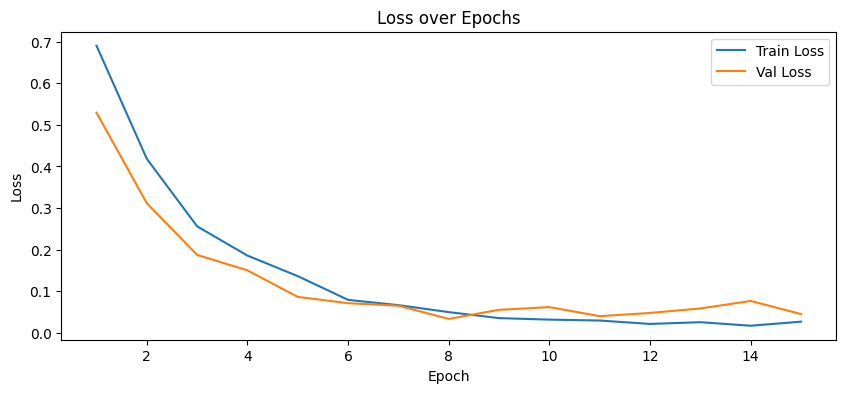

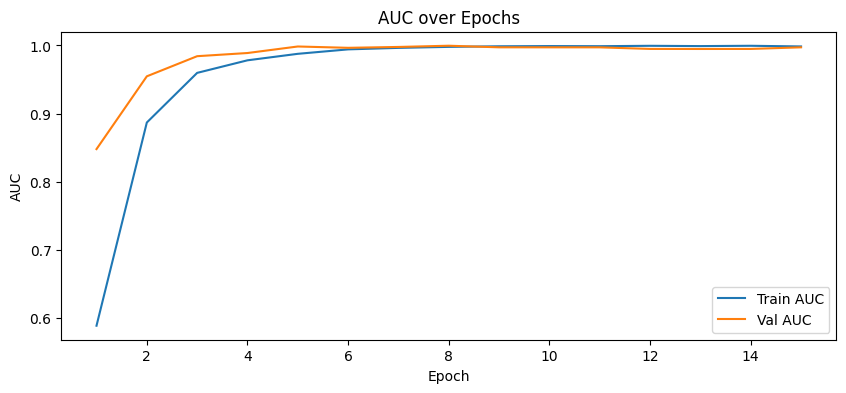

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 615ms/step


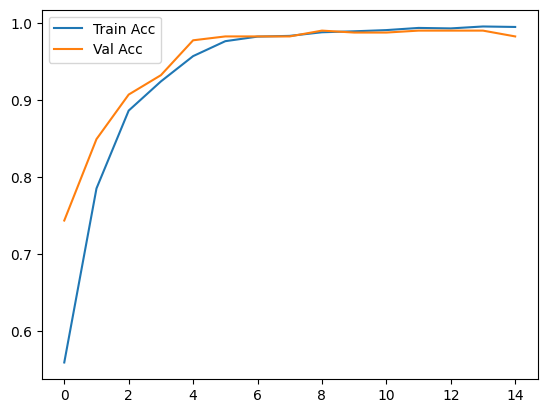

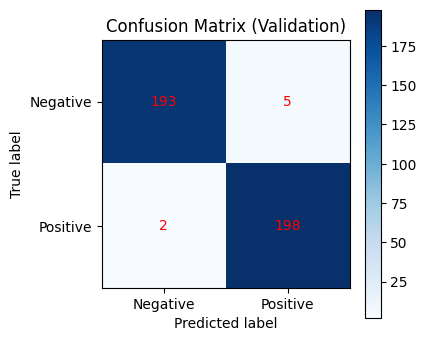

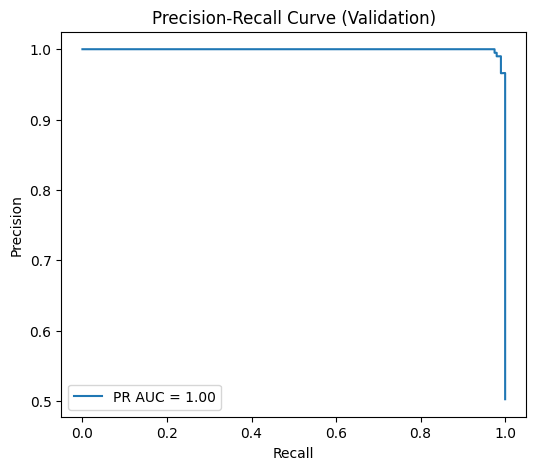

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


[Grad‑CAM] Yellow cloth_041.png: heatmap range 0.000–1.000


/tmp/ipython-input-1122171184.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


[Grad‑CAM] Yellow cloth_a21e7e9847084731b0d81823126eaba8.png: heatmap range 0.000–0.033


epoch/accuracy,▁▅▆▇▇██████████
epoch/auc,▁▆▇████████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,█▇▇▆▅▃▂▂▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch/precision,▁▄▆▆▇██████████
epoch/recall,▁▅▇▇███████████
epoch/val_accuracy,▁▄▆▆███████████
epoch/val_auc,▁▆▇████████████
epoch/val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▂▁
epoch/val_precision,▃▅▁▆██▇▇██▇███▇


wandb: Agent Starting Run: 2iycdnyk with config:
wandb: 	activation: gelu
wandb: 	attention_heads: 2
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.4110599074989422
wandb: 	dropout_type: standard
wandb: 	hidden_layers: 2
wandb: 	hidden_units: 128
wandb: 	img_size: 256
wandb: 	lr: 0.0008111791845036733
wandb: 	momentum: 0.9
wandb: 	optimizer: AdamW
wandb: 	scheduler: exponential
wandb: 	se_ratio: 12
wandb: 	transformer_blocks: 3


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 391ms/step - accuracy: 0.5265 - auc: 0.5399 - loss: 0.7652 - precision: 0.5338 - recall: 0.5374 - val_accuracy: 0.7161 - val_auc: 0.8187 - val_loss: 0.6406 - val_precision: 0.8919 - val_recall: 0.4950
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 302ms/step - accuracy: 0.7199 - auc: 0.8070 - loss: 0.5291 - precision: 0.7267 - recall: 0.7223 - val_accuracy: 0.8618 - val_auc: 0.9514 - val_loss: 0.3111 - val_precision: 0.8836 - val_recall: 0.8350
Epoch 3/30
 56/100 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.8462 - auc: 0.9301 - loss: 0.3300 - precision: 0.8338 - recall: 0.8741

In [ ]:
# ============ SWEEP & MAIN ============

if __name__ == '__main__':
    import tensorflow as tf
    from tensorflow import keras
    from sklearn.metrics import precision_score, recall_score, f1_score

    # Mount Google Drive if needed (in Colab)
    from google.colab import drive
    drive.mount('/content/drive')

    # Launch W&B sweep and train
    sweep_id = wandb.sweep(sweep_config, project="confinal-tuning")
    # best_id =
    wandb.agent(sweep_id, train, count=10)

    # === now fetch all runs in this sweep and pick best ===
    api   = wandb.Api()
    # entity/project/sweep_id
    sweep = api.sweep(f"{api.default_entity}/confinal-tuning/{sweep_id}")
    all_runs = sweep.runs
    # pick the run with highest validation AUC
    best_run = max(all_runs, key=lambda r: r.summary_metrics.get("val_auc", 0.0))
    best_id  = best_run.id
    # # Retrieve best run configuration and model weights
    # api = wandb.Api()
    # best_run = api.run(f"ca-tuning/{best_id}")
    best_cfg = best_run.config
    best_path = f'best_model_{best_id}.keras'  # or .h5 if saved that way

    # Rebuild and load the best model
    model = HybridModel(best_cfg)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_cfg['lr']),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[AUC(name='auc'), BinaryAccuracy(name='accuracy'),
                 Precision(name='precision'), Recall(name='recall')]
    )
    model.load_weights(best_path)

    # Prepare test dataset
    test_ds = tf.keras.utils.image_dataset_from_directory(
        '/content/drive/MyDrive/VGG/test',
        labels='inferred', label_mode='binary',
        image_size=(256, 256), batch_size=best_cfg['batch_size'], shuffle=False
    )
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    # Evaluate on test data
    test_probs = model.predict(test_ds).flatten()
    test_labels = np.concatenate([y.numpy() for x, y in test_ds])
    test_pred_labels = (test_probs > 0.5).astype(np.int32)

    test_auc = roc_auc_score(test_labels, test_probs)
    test_accuracy = accuracy_score(test_labels, test_pred_labels)
    test_precision = precision_score(test_labels, test_pred_labels)
    test_recall = recall_score(test_labels, test_pred_labels)
    test_f1 = f1_score(test_labels, test_pred_labels)

    # Log final test metrics
    print(f"Test AUC: {test_auc:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
    wandb.log({
        'final_test_auc': test_auc,
        'final_test_accuracy': test_accuracy,
        'final_test_precision': test_precision,
        'final_test_recall': test_recall,
        'final_test_f1': test_f1
    })

    # Confusion matrix for test data
    cm_test = confusion_matrix(test_labels, test_pred_labels)
    plt.figure(figsize=(4, 4))
    plt.imshow(cm_test, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Test)')
    plt.colorbar()
    plt.xticks(tick_marks, classes); plt.yticks(tick_marks, classes)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm_test[i, j], ha="center", va="center", color="red")
    plt.xlabel('Predicted label'); plt.ylabel('True label')
    wandb.log({'confusion_matrix_test': wandb.Image(plt)})
    plt.show()

    # Precision-Recall curve on test data
    precisions, recalls, _ = precision_recall_curve(test_labels, test_probs)
    pr_auc_test = sk_auc(recalls, precisions)
    plt.figure(figsize=(6, 5))
    plt.plot(recalls, precisions, label=f'PR AUC = {pr_auc_test:.2f}')
    plt.title('Precision-Recall Curve (Test)')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend()
    wandb.log({'pr_curve_test': wandb.Image(plt)})
    plt.show()

    def make_gradcam_heatmap(img_array, model):
            with tf.GradientTape() as tape:
                conv_outputs, preds = model.gradcam_forward(img_array, training=False)
                tape.watch(conv_outputs)

                pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]



            grads        = tape.gradient(class_channel, conv_outputs)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            conv_outputs = conv_outputs[0]
            heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
            return heatmap.numpy()

    def superimpose_gradcam(img_path, heatmap, alpha=0.4):
            # Use captured img_size
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
            img = tf.keras.preprocessing.image.img_to_array(img)
            heatmap_uint8 = np.uint8(255 * heatmap)
            jet = plt.cm.get_cmap("jet")
            jet_colors = jet(np.arange(256))[:, :3]
            jet_heatmap = jet_colors[heatmap_uint8]
            jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
            jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
            jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
            superimposed = jet_heatmap * alpha + img
            return tf.keras.preprocessing.image.array_to_img(superimposed)

    sample_dir = '/content/drive/MyDrive/VGG/test/defect'
    for i, fname in enumerate(tf.io.gfile.listdir(sample_dir)[:2]):
            img_path = os.path.join(sample_dir, fname)

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))

            img_arr = tf.keras.preprocessing.image.img_to_array(img)
            img_arr = np.expand_dims(img_arr, axis=0)
            img_arr = preprocess_input(img_arr)

            # img_arr = tf.keras.preprocessing.image.img_to_array(
            #     tf.keras.preprocessing.image.load_img(img_path, (img_size, img_size))
            # )
            heatmap = make_gradcam_heatmap(img_arr, model)
            print(f"[Grad‑CAM] {fname}: heatmap range {heatmap.min():.3f}–{heatmap.max():.3f}")
            cam_img = superimpose_gradcam(img_path, heatmap)
            wandb.log({f'gradcam_val_{i}': wandb.Image(cam_img)})



    print("Final test metrics logged to W&B.")
